In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg16 import VGG16

import numpy as np
import matplotlib.pyplot as plt

from skimage import io
import cv2

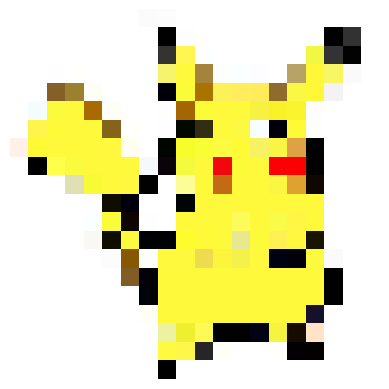

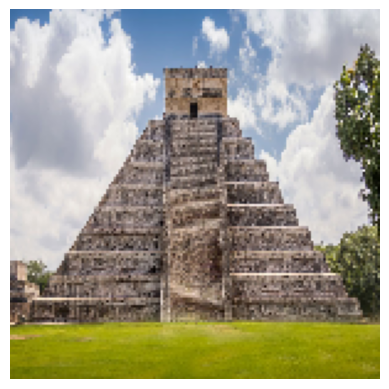

In [2]:
Pikachu = io.imread('http://pm1.narvii.com/6722/0ab8cce1e61ba0ef3beec0823b2c5321d1716fef_00.jpg')
Pikachu = cv2.resize(Pikachu[:,:,:3], (20,20))

Background = io.imread('https://cdn.britannica.com/49/61349-050-9FFBEB28/El-Castillo-pyramid-plaza-Toltec-state-Yucatan.jpg')
Background = cv2.resize(Background[:,:,:3], (150,150))

plt.imshow( Pikachu )
plt.axis('off');
plt.show()
plt.imshow( Background )
plt.axis('off');
plt.show()

5 outputs for the model:
- Px
- Py
- Tx
- Ty
- P(o|x)

In [7]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=[150,150,3])

x = Flatten()(vgg16.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(256, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal())(x)
x = tf.keras.layers.Dropout(0.35)(x)
x = Dense(128, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal())(x)
x = tf.keras.layers.Dropout(0.35)(x)
x = Dense(64, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal())(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(5, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.RandomNormal())(x)

model = Model(vgg16.input, x)

In [8]:
def Image_Generator(batch_size = 128):

  while True:

    for _ in range(100):

      X = np.ones((batch_size,150,150,3))*Background.copy()
      Y = np.zeros((batch_size, 5))

      for i in range(batch_size):
        
        #Case where Pikachu is in the image
        if np.random.random() > 0.15:
          n_w = np.random.randint(20, 80)
          n_h = np.random.randint(20, 80)

          row_1 = np.random.randint(0, 150 - n_h)
          col_1 = np.random.randint(0, 150 - n_w)
          row_2 = row_1 + n_h
          col_2 = col_1 + n_w
          
          #Add pikachu without background
          b_slice = X[i, row_1:row_2, col_1:col_2, :]
          img = cv2.resize(Pikachu, (n_w, n_h))
          mask = (img == 255)
          
          b_slice =  mask * b_slice
          b_slice += img

          X[i, row_1:row_2, col_1:col_2, :] = b_slice
          Y[i,0] = row_1 / 150
          Y[i,1] = col_1 / 150
          Y[i,2] = (row_2 - row_1) / 150 
          Y[i,3] = (col_2 - col_1) / 150 
          Y[i,4] = 1
        else:
          #case where there is no pikachu
          Y[i,4] = 0
        
      yield X / 255.0 , Y

In [9]:
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-3), metrics=['accuracy'])
model.fit(Image_Generator(), steps_per_epoch=100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 54s 526ms/step - loss: 0.5750 - accuracy: 0.8416
Epoch 2/10
100/100 [==============================] - 53s 528ms/step - loss: 0.4158 - accuracy: 0.9373
Epoch 3/10
100/100 [==============================] - 53s 526ms/step - loss: 0.4057 - accuracy: 0.9529
Epoch 4/10
100/100 [==============================] - 51s 510ms/step - loss: 0.3973 - accuracy: 0.9605
Epoch 5/10
100/100 [==============================] - 51s 510ms/step - loss: 0.3952 - accuracy: 0.9646
Epoch 6/10
100/100 [==============================] - 51s 511ms/step - loss: 0.3968 - accuracy: 0.9652
Epoch 7/10
100/100 [==============================] - 52s 517ms/step - loss: 0.3951 - accuracy: 0.9576
Epoch 8/10
100/100 [==============================] - 52s 516ms/step - loss: 0.3936 - accuracy: 0.9545
Epoch 9/10
100/100 [==============================] - 53s 530ms/step - loss: 0.3935 - accuracy: 0.9596
Epoch 10/10
100/100 [==============================] - 51s 510ms/step - l

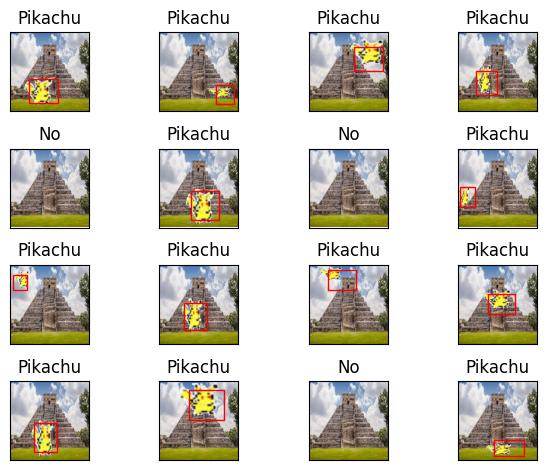

In [10]:
from matplotlib.patches import Rectangle
from itertools import product

fig, ax = plt.subplots(4,4)



for i,j in product(range(4), range(4)):
  x = Background.copy()

  if np.random.random() > 0.2:
    n_w = np.random.randint(20, 80)
    n_h = np.random.randint(20, 80)

    row_1 = np.random.randint(0, 150 - n_h)
    col_1 = np.random.randint(0, 150 - n_w)
    row_2 = row_1 + n_h
    col_2 = col_1 + n_w

    b_slice = x[row_1:row_2, col_1:col_2, :]
    img = cv2.resize(Pikachu, (n_w, n_h))
    mask = (img == 255)
  
    b_slice =  mask * b_slice
    b_slice += img

    x[row_1:row_2, col_1:col_2, :] = b_slice

  x = np.expand_dims(x, axis = 0)
  p = model(x / 255, training = False)[0]

  #print(np.round([row_1/150,col_1/150, (row_2 - row_1) / 150 , (col_2 - col_1) / 150 ],2),p)

  ax[i][j].imshow(x[0].astype('uint8'))

  if(p[4] > 0.5):
    rect = Rectangle((p[1]*150, p[0]*150), p[3]*150, p[2]*150, linewidth = 1, edgecolor = 'r', facecolor = 'none')
    ax[i][j].add_patch(rect)
    
  ax[i][j].set_title("Pikachu" if p[4] > 0.5 else "No")
  ax[i][j].set_yticks([])
  ax[i][j].set_xticks([])

fig.tight_layout()
plt.show()